In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import more_itertools as mit

In [2]:
from libs.solution.initial_solution_creators.heuristic import *
from libs.solution.initial_solution_creators.random import *
from libs.utils.matrix import extend_cost_mx
from libs.optimizers.algorithms.genetic.operators.fixers import *
from libs.optimizers.algorithms.genetic.operators.mutations import *
from libs.optimizers.algorithms.genetic.operators.crossovers import *
from libs.environment.cost_calculators import *
from libs.optimizers.algorithms.genetic.population.parent_selectors import *
from libs.optimizers.algorithms.genetic.population.natural_selection import *

In [3]:
rng = np.random.default_rng()
initial_vx = 0
forbidden_val = -1
salesman_n = 3
vehicle_volume = 10
fix_max_add_iters = 100
fix_max_retries = 1
forbidding_p = 0.15
default_quantity = 0.1

<AxesSubplot:>

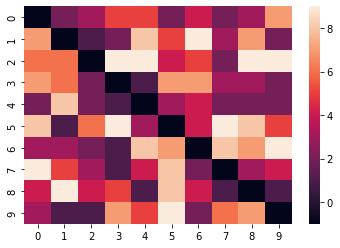

In [4]:
N = 10
dist_mx = rng.integers(1, 10, size=(N, N))
np.fill_diagonal(dist_mx, forbidden_val)
sns.heatmap(dist_mx)

<AxesSubplot:>

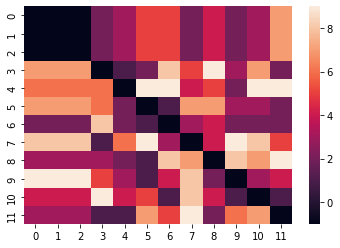

In [5]:
ext_dist_mx = extend_cost_mx(dist_mx, copy_n=salesman_n - 1, to_copy_ix=0)
ini_and_dummy_vxs = {initial_vx, *range(salesman_n)}
sns.heatmap(ext_dist_mx)

## Solution generators

In [7]:
sol_tsp_r, rng = create_tsp_sol_rand(dist_mx, initial_vx, rng)
sol_tsp_r, check_chromosome_tsp(sol_tsp_r, dist_mx, initial_vx, forbidden_val)

([0, 9, 1, 7, 4, 5, 3, 8, 6, 2, 0], True)

In [8]:
sol_tsp_h = create_tsp_sol_nn(dist_mx, initial_vx, forbidden_val)
sol_tsp_h, check_chromosome_tsp(sol_tsp_h, dist_mx, initial_vx, forbidden_val)

([0, 6, 7, 1, 9, 2, 5, 8, 3, 4, 0], True)

In [9]:
sol_vrp_r, rng = create_vrp_sol_rand(
    ext_dist_mx, initial_vx, rng, ini_and_dummy_vxs, regular_vx_division=True
)
sol_vrp_r, check_chromosome_tsp(sol_vrp_r, ext_dist_mx, initial_vx, forbidden_val)

([0, 6, 10, 7, 1, 8, 11, 4, 2, 3, 5, 9, 0], True)

In [10]:
sol_vrp_h = create_tsp_sol_nn(ext_dist_mx, initial_vx, forbidden_val)
sol_vrp_h, check_chromosome_tsp(sol_vrp_h, ext_dist_mx, initial_vx, forbidden_val)

([0, 8, 9, 3, 11, 4, 1, 7, 10, 2, 5, 6, 0], True)

In [11]:
sol_irp_seq_r, sol_irp_qs_r, rng = create_irp_sol_rand(
    ext_dist_mx,
    initial_vx,
    rng,
    ini_and_dummy_vxs,
    vehicle_volume,
    regular_vx_division=True,
)
sol_irp_seq_r, sol_irp_qs_r.tolist(), check_chromosome_tsp(
    sol_irp_seq_r, ext_dist_mx, initial_vx, forbidden_val
)

([0, 7, 9, 4, 1, 8, 5, 6, 2, 11, 10, 3, 0],
 [0.0,
  0.7653439674941728,
  1.906321856030984,
  2.2495212980602908,
  0.0,
  2.5665205890743596,
  0.49082805270100355,
  0.12467495430483413,
  0.0,
  0.6093183320016428,
  0.8639899136132194,
  0.4234810367194918,
  0.0],
 True)

In [12]:
mask = rng.random(size=dist_mx.shape) < forbidding_p
mask_ext = rng.random(size=ext_dist_mx.shape) < forbidding_p
masked_dist_mx = dist_mx.copy()
masked_ext_dist_mx = ext_dist_mx.copy()
masked_dist_mx[mask] = forbidden_val
masked_ext_dist_mx[mask_ext] = forbidden_val

## Fixers

In [13]:
from time import perf_counter


def fixer_check_tsp(
    masked_dist_mx: np.ndarray, rng: np.random.Generator, iter_n: int = 1000
):
    no_of_failures = 0
    total_t = 0
    for i in range(iter_n):
        initial_vx = 0
        vx_pool = list(range(1, len(masked_dist_mx)))
        to_exclude = 3
        rand_ixs = (
            [3]
            + list(
                rng.choice(
                    [x for x in vx_pool if x != to_exclude],
                    size=len(masked_dist_mx) - 1,
                )
            )
            + [initial_vx]
        )
        try:
            t0 = perf_counter()
            fixed_ch, fix_status = fix_tsp(
                rand_ixs,
                masked_dist_mx,
                initial_vx,
                forbidden_val,
                fix_max_add_iters,
                fix_max_retries,
            )
            total_t += perf_counter() - t0
        except Exception as e:
            print(f"exception at iteration {i}/{iter_n}")
            raise e
        if not fix_status:
            no_of_failures += 1

    print(f"{no_of_failures = } / {iter_n}")
    print(f"fail_rate: {no_of_failures / iter_n * 100:.2f}%")
    print(f"mean time: {total_t / (iter_n - no_of_failures)}\ntotal time: {total_t}")


def fixer_check_sdvrp(
    masked_dist_mx: np.ndarray, rng: np.random.Generator, iter_n: int = 1000
):
    no_of_failures = 0
    total_t = 0
    for i in range(iter_n):
        initial_vx = 0
        vx_pool = list(range(1, len(masked_dist_mx)))
        to_exclude = 3
        rand_ixs = (
            [3]
            + list(
                rng.choice(
                    [x for x in vx_pool if x != to_exclude],
                    size=len(masked_dist_mx) - 1,
                )
            )
            + [initial_vx]
        )
        try:
            t0 = perf_counter()
            fixed_ch, fix_status = fix_sdvrp(
                rand_ixs,
                masked_dist_mx,
                initial_vx,
                forbidden_val,
                fix_max_add_iters,
                fix_max_retries,
            )
            total_t += perf_counter() - t0
        except Exception as e:
            print(f"exception at iteration {i}/{iter_n}")
            raise e
        if not fix_status:
            no_of_failures += 1

    print(f"{no_of_failures = } / {iter_n}")
    print(f"fail_rate: {no_of_failures / iter_n * 100:.2f}%")
    print(f"mean time: {total_t / (iter_n - no_of_failures)}\ntotal time: {total_t}")


def fixer_check_irp(
    masked_dist_mx: np.ndarray, rng: np.random.Generator, iter_n: int = 1000
):
    no_of_failures = 0
    total_t = 0
    for i in range(iter_n):
        initial_vx = 0
        vx_pool = list(range(1, len(masked_dist_mx)))
        to_exclude = 3
        rand_ixs = (
            [3]
            + list(
                rng.choice(
                    [x for x in vx_pool if x != to_exclude],
                    size=len(masked_dist_mx) - 1,
                )
            )
            + [initial_vx]
        )
        rand_qs = rng.random(size=len(rand_ixs)).tolist()
        try:
            t0 = perf_counter()
            fixed_seq, fixed_qs, fix_status = fix_irp(
                rand_ixs,
                masked_dist_mx,
                initial_vx,
                forbidden_val,
                fix_max_add_iters,
                fix_max_retries,
                default_quantity=default_quantity,
                quantities=rand_qs,
            )
            total_t += perf_counter() - t0
        except Exception as e:
            print(f"exception at iteration {i}/{iter_n}")
            raise e
        if not fix_status:
            no_of_failures += 1

    print(f"{no_of_failures = } / {iter_n}")
    print(f"fail_rate: {no_of_failures / iter_n * 100:.2f}%")
    print(f"mean time: {total_t / (iter_n - no_of_failures)}\ntotal time: {total_t}")

In [14]:
ITER_N = 10000

In [15]:
fixer_check_tsp(masked_dist_mx, rng, iter_n=ITER_N)

no_of_failures = 3 / 10000
fail_rate: 0.03%
mean time: 0.00010660908272481866
total time: 1.0657710000000122


In [16]:
# for vrp the same fixer is appropriate
fixer_check_tsp(masked_ext_dist_mx, rng, iter_n=ITER_N)

no_of_failures = 29 / 10000
fail_rate: 0.29%
mean time: 0.00015629544679573667
total time: 1.5584219000002903


In [17]:
fixer_check_sdvrp(masked_ext_dist_mx, rng, iter_n=ITER_N)

no_of_failures = 13 / 10000
fail_rate: 0.13%
mean time: 7.197362571338849e-05
total time: 0.7188005999996108


In [18]:
fixer_check_irp(masked_ext_dist_mx, rng, iter_n=ITER_N)

# print(f"seq: {fvxs}")
# print(",".join(f"({x}:{y:.2f})" for x, y in zip(fvxs, fqs)))
# print([masked_ext_dist_mx[a, b] for a, b in mit.windowed(fvxs, n=2)])
# print(f"doubles? [{set(fvxs) == set(range(masked_ext_dist_mx.shape[0]))}]")

no_of_failures = 12 / 10000
fail_rate: 0.12%
mean time: 7.08948338005616e-05
total time: 0.7080976000000092


## Mutations

In [19]:
c_mid = np.arange(1, 11)
c = np.array([0] + c_mid.tolist() + [0])
c

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0])

In [20]:
mutate_swap(c.copy(), p=0.2, rng=rng)

(array([ 5,  6,  2,  3,  4,  8,  1,  7,  0,  9, 10,  0]),
 Generator(PCG64) at 0x1A4D18C62E0)

In [21]:
mutate_del(c.copy(), p=0.2, rng=rng, fillval=-1)

(array([ 0,  1,  2,  3,  4,  5, -1,  7, -1, -1, 10, -1]),
 Generator(PCG64) at 0x1A4D18C62E0)

In [22]:
mutate_insert(
    c.copy(),
    p=0.2,
    rng=rng,
    rand_range=(1, c.max()),
    ini_and_dummy_vxs={0, 1},
    fillval=-1,
)

(array([ 6,  0,  6,  1,  2,  3,  4,  5,  9,  6,  7,  8,  9, 10,  0]),
 Generator(PCG64) at 0x1A4D18C62E0)

In [23]:
qs = rng.random(size=c.shape)
qs

array([0.56803724, 0.74589111, 0.53721028, 0.22209232, 0.67269851,
       0.25584406, 0.59085444, 0.25153294, 0.42900116, 0.86131097,
       0.75848044, 0.77020519])

In [24]:
mutate_swap_irp(c.copy(), p=0.2, rng=rng, quantities=qs.copy())

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  0, 10,  9]),
 array([0.56803724, 0.74589111, 0.53721028, 0.22209232, 0.67269851,
        0.25584406, 0.59085444, 0.25153294, 0.42900116, 0.77020519,
        0.75848044, 0.86131097]),
 Generator(PCG64) at 0x1A4D18C62E0)

In [25]:
mutate_del_irp(c.copy(), p=0.2, rng=rng, quantities=qs.copy(), fillval=-1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1, -1]),
 Generator(PCG64) at 0x1A4D18C62E0)

In [26]:
mutate_insert_irp(
    # c.copy(),
    -np.ones(shape=c.shape),
    p=0.2,
    rng=rng,
    quantities=qs,
    fillval=-1,
    rand_vx_range=(1, c.shape[0] - 2),
    ini_and_dummy_vxs={0, 1},
    rand_quantity_range=(0.1, 0.5),
)

(array([-1.,  8., -1., -1., -1.,  9., -1., -1., -1.,  8., -1., -1.]),
 array([-1.,  8., -1., -1., -1.,  9., -1., -1., -1.,  8., -1., -1.]),
 Generator(PCG64) at 0x1A4D18C62E0)

## Crossovers

In [27]:
p1 = np.fromiter((0, *range(1, 10), 0), dtype=np.int64)
p2 = np.fromiter(reversed(p1), dtype=np.int64)
p1

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0], dtype=int64)

In [28]:
p2

array([0, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0], dtype=int64)

In [29]:
c1, c2, rng = crossover_ndarray(p1, p2, rng)
c1, c2

(array([0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0], dtype=int64),
 array([0, 9, 8, 7, 6, 5, 6, 7, 8, 9, 0], dtype=int64))

In [30]:
c1, c2, rng = crossover_k_loci_ndarray(p1, p2, rng, k=3)
c1, c2

(array([0, 1, 8, 7, 6, 5, 4, 7, 8, 1, 0], dtype=int64),
 array([0, 9, 2, 3, 4, 5, 6, 3, 2, 9, 0], dtype=int64))

In [31]:
c1, c2, rng = crossover_k_loci_poisson_ndarray(p1, p2, rng, lam=1)
c1, c2

(array([0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0], dtype=int64),
 array([0, 9, 8, 7, 6, 5, 6, 7, 8, 9, 0], dtype=int64))

In [32]:
c1, c2, rng = crossover_k_loci_with_inversion_ndarray(
    p1, -p2, rng, k=3, inversion_p=0.5
)
c1, c2

(array([ 0,  1,  2,  3, -6, -5,  6,  7, -2, -1,  0], dtype=int64),
 array([ 0, -9, -8, -7,  5,  4, -4, -3,  0,  9,  8], dtype=int64))

In [33]:
c1, c2, rng = crossover_k_loci_poisson_with_inversion_ndarray(
    p1, -p2, rng, lam=1, inversion_p=0.5
)
c1, c2

(array([ 0,  1,  2, -6, -7,  7,  6,  5, -2, -1,  0], dtype=int64),
 array([-8, -9,  0,  4,  3, -3, -4, -5,  8,  9,  0], dtype=int64))

### IRP

In [34]:
s1 = np.fromiter((0, *range(1, 10), 0), dtype=np.int64)
s2 = np.fromiter(reversed(s1), dtype=np.int64)
qs1 = np.linspace(0, 1, s1.shape[0])
qs2 = -qs1.copy()
p1 = np.stack((s1, qs1), axis=1)
p2 = np.stack((s2, qs2), axis=1)
p1.T

array([[0. , 1. , 2. , 3. , 4. , 5. , 6. , 7. , 8. , 9. , 0. ],
       [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]])

In [35]:
p2.T

array([[ 0. ,  9. ,  8. ,  7. ,  6. ,  5. ,  4. ,  3. ,  2. ,  1. ,  0. ],
       [-0. , -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1. ]])

In [36]:
c1, c2, rng = crossover_ndarray(p1, p2, rng)
c1.T, c2.T

(array([[ 0. ,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  3. ,  2. ,  1. ,  0. ],
        [ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6, -0.7, -0.8, -0.9, -1. ]]),
 array([[ 0. ,  9. ,  8. ,  7. ,  6. ,  5. ,  4. ,  7. ,  8. ,  9. ,  0. ],
        [-0. , -0.1, -0.2, -0.3, -0.4, -0.5, -0.6,  0.7,  0.8,  0.9,  1. ]]))

In [37]:
c1, c2, rng = crossover_k_loci_ndarray(p1, p2, rng, k=3)
c1.T, c2.T

(array([[ 0. ,  1. ,  8. ,  7. ,  6. ,  5. ,  6. ,  7. ,  8. ,  1. ,  0. ],
        [ 0. ,  0.1, -0.2, -0.3, -0.4,  0.5,  0.6,  0.7,  0.8, -0.9, -1. ]]),
 array([[ 0. ,  9. ,  2. ,  3. ,  4. ,  5. ,  4. ,  3. ,  2. ,  9. ,  0. ],
        [-0. , -0.1,  0.2,  0.3,  0.4, -0.5, -0.6, -0.7, -0.8,  0.9,  1. ]]))

In [38]:
c1, c2, rng = crossover_k_loci_poisson_ndarray(p1, p2, rng, lam=1)
c1.T, c2.T

(array([[ 0. ,  1. ,  8. ,  7. ,  6. ,  5. ,  6. ,  7. ,  8. ,  1. ,  0. ],
        [ 0. ,  0.1, -0.2, -0.3, -0.4, -0.5,  0.6,  0.7,  0.8, -0.9, -1. ]]),
 array([[ 0. ,  9. ,  2. ,  3. ,  4. ,  5. ,  4. ,  3. ,  2. ,  9. ,  0. ],
        [-0. , -0.1,  0.2,  0.3,  0.4,  0.5, -0.6, -0.7, -0.8,  0.9,  1. ]]))

In [39]:
c1, c2, rng = crossover_k_loci_with_inversion_ndarray(
    p1, -p2, rng, k=3, inversion_p=0.5
)
c1.T, c2.T

(array([[ 0. , -9. , -8. ,  4. ,  3. , -0. , -1. , -2. , -3. , -4. , -5. ],
        [ 0. ,  0.1,  0.2,  0.4,  0.3,  1. ,  0.9,  0.8,  0.7,  0.6,  0.5]]),
 array([[-0. ,  1. ,  2. , -6. , -7. ,  5. ,  6. ,  7. ,  8. ,  9. ,  0. ],
        [ 0. ,  0.1,  0.2,  0.4,  0.3,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]]))

In [40]:
c1, c2, rng = crossover_k_loci_poisson_with_inversion_ndarray(
    p1, -p2, rng, lam=1, inversion_p=0.5
)
c1.T, c2.T

(array([[ 0. , -7. , -8. , -9. ,  6. ,  5. ,  4. , -3. , -2. ,  9. ,  0. ],
        [ 0. ,  0.3,  0.2,  0.1,  0.6,  0.5,  0.4,  0.7,  0.8,  0.9,  1. ]]),
 array([[-0. ,  3. ,  2. ,  1. , -6. , -5. , -4. ,  7. ,  8. , -0. , -1. ],
        [ 0. ,  0.3,  0.2,  0.1,  0.4,  0.5,  0.6,  0.7,  0.8,  1. ,  0.9]]))

## Costs

In [6]:
N = 10
fv = -1
speed = 2.5
max_wind_speed = 2
T = 100
window_n = 10
win_span = T / window_n
dist_mx = rng.uniform(0.1, 10, size=(N, N))
np.fill_diagonal(dist_mx, fv)
dyn_costs = []
exp_t = win_span
while exp_t < T:
    wind_mx = rng.uniform(-max_wind_speed, max_wind_speed, size=dist_mx.shape)
    eff_speed = wind_mx + speed
    eff_speed[eff_speed < 0] = 0
    np.fill_diagonal(wind_mx, fv)
    dyn_costs.append((eff_speed, exp_t))
    exp_t += win_span

In [7]:
seq_tsp = [
    0,
    *rng.choice(range(1, dist_mx.shape[0]), size=dist_mx.shape[0] - 1, replace=False),
    0,
]
seq_tsp

[0, 5, 1, 2, 4, 9, 6, 7, 3, 8, 0]

In [8]:
cost_calc_tsp(seq_tsp, dyn_costs, dist_mx, initial_vx=0, forbidden_val=fv)

27.35068344366533

[0, 5, 7, 8, 1, 9, 4, 6, 2, 10, 3, 0]

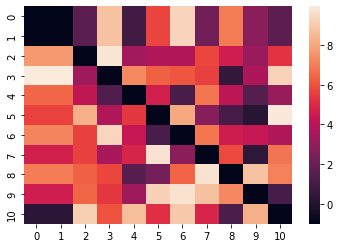

In [9]:
ext_dist_mx = extend_cost_mx(dist_mx, copy_n=1, to_copy_ix=0)
seq_vrp = list(range(1, ext_dist_mx.shape[0]))
rng.shuffle(seq_vrp)
seq_vrp = [0] + seq_vrp + [0]
seq_vrp
import seaborn as sns

sns.heatmap(ext_dist_mx)
seq_vrp

In [14]:
dyn_costs = []
exp_t = win_span
while exp_t < T:
    wind_mx = rng.uniform(-max_wind_speed, max_wind_speed, size=ext_dist_mx.shape)
    eff_speed = wind_mx + speed
    eff_speed[eff_speed < 0] = 0
    np.fill_diagonal(wind_mx, fv)
    dyn_costs.append((eff_speed, exp_t))
    exp_t += win_span

In [15]:
cost_calc_vrp(
    seq_vrp,
    dyn_costs,
    ext_dist_mx,
    initial_vx=0,
    forbidden_val=-1,
    ini_and_dummy_vxs={0, 1},
)

17.864888681750497

In [ ]:
cost_calc_sdvrp(seq_vrp, dyn_costs, ext_dist_mx, fv, initial_vx, ini_and_dummy_vxs={0, 1}, demands=demands, w1)